In [2]:
import pandas as pd
from tomlkit import document
data_path = '../data/Session-Summary-all-2025-S1.csv'  # Adjust path if needed
df = pd.read_csv(data_path, encoding='latin1')  

documents = df.astype(str).apply(lambda row: ' '.join(row.values), axis=1)
print(f"Number of documents: {len(documents)}")

Number of documents: 2548


In [3]:
# Preprocess text: combine Topic and YourAnalysis, clean, remove stopwords, lemmatize
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download NLTK resources if not already present
nltk.download('stopwords')
nltk.download('wordnet')

def preprocess_text(row):
    # Combine Topic and YourAnalysis columns
    text = str(row['Topic']) + ' ' + str(row['YourAnalysis'])
    # Remove special characters
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    # Lowercase and tokenize
    tokens = text.lower().split()
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

df['preprocessed_text'] = df.apply(preprocess_text, axis=1)
print(df[['Topic', 'YourAnalysis', 'preprocessed_text']].head())

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pravi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\pravi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


                                               Topic  \
0                              Level of measurement    
1                             Levels of measurements   
2                              Levels of Measurement   
3  types of arithmetic and statistical operation ...   
4  Statistical Measurement Levels and Classes of ...   

                                        YourAnalysis  \
0  Learned about nominal, ordinal, interval and r...   
1  Levels of Measurement:\n1). Nominal : where th...   
2  Levels of Measurement ( also called scales of ...   
3  there are various levels of data beginning wit...   
4  Every problem in machine learning can be categ...   

                                   preprocessed_text  
0  level measurement learned nominal ordinal inte...  
1  level measurement level measurement 1 nominal ...  
2  level measurement level measurement also calle...  
3  type arithmetic statistical operation performe...  
4  statistical measurement level class machine le..

In [4]:
# Add total number of words and characters for each document
df['word_count'] = df['preprocessed_text'].apply(lambda x: len(x.split()))
df['char_count'] = df['preprocessed_text'].apply(len)
print(df[['preprocessed_text', 'word_count', 'char_count']].head())

                                   preprocessed_text  word_count  char_count
0  level measurement learned nominal ordinal inte...          15         125
1  level measurement level measurement 1 nominal ...         103         670
2  level measurement level measurement also calle...         191        1285
3  type arithmetic statistical operation performe...         281        2031
4  statistical measurement level class machine le...         269        2035


In [5]:
# Vectorize documents: CountVectorizer, TfidfVectorizer, Word2Vec


from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec
import numpy as np

# a. Count Vectorization
count_vec = CountVectorizer()
count_matrix = count_vec.fit_transform(df['preprocessed_text'])
df['count_vector'] = list(count_matrix.toarray())

# b. TFIDF Vectorization
tfidf_vec = TfidfVectorizer()
tfidf_matrix = tfidf_vec.fit_transform(df['preprocessed_text'])
df['tfidf_vector'] = list(tfidf_matrix.toarray())

# c. Word2Vec Vectorization (average word vectors per document)
tokenized_docs = [doc.split() for doc in df['preprocessed_text']]
w2v_model = Word2Vec(sentences=tokenized_docs, vector_size=100, window=5, min_count=1, workers=2, seed=42)
def document_vector(doc):
    # Average word vectors for words in the document
    vectors = [w2v_model.wv[word] for word in doc if word in w2v_model.wv]
    if len(vectors) == 0:
        return np.zeros(w2v_model.vector_size)
    return np.mean(vectors, axis=0)
df['word2vec_vector'] = [document_vector(doc) for doc in tokenized_docs]

print("Vectorization complete. Sample vectors:")
print("Count vector:", df['count_vector'].iloc[0][:10])
print("TFIDF vector:", df['tfidf_vector'].iloc[0][:10])
print("Word2Vec vector:", df['word2vec_vector'].iloc[0][:10])

Vectorization complete. Sample vectors:
Count vector: [0 0 0 0 0 0 0 0 0 0]
TFIDF vector: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Word2Vec vector: [-0.3567517  -0.18859178 -0.47779328 -0.43367508  0.33150616  0.08112715
 -0.22166802 -0.4255953  -0.5265175   0.42776066]


In [6]:
#Save the dataframe into a spreadsheet and review all the created dataframes
df.to_excel("vectorized_documents.xlsx", index=False)   

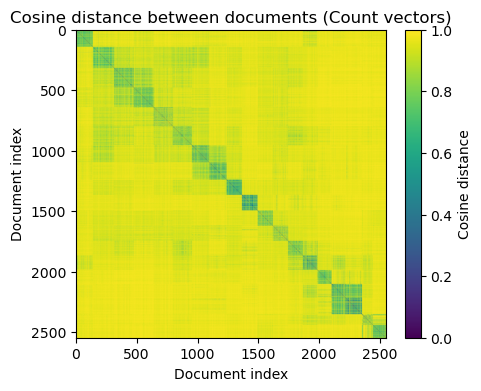

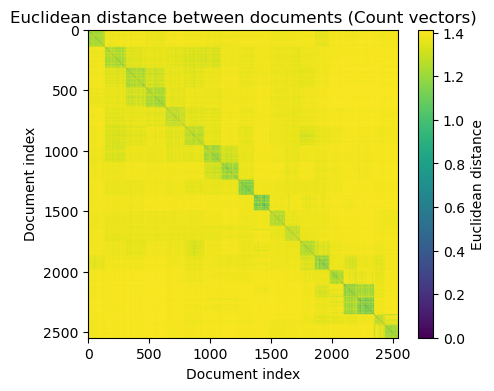

In [9]:
# Pairwise cosine and Euclidean distances for TF-IDF vectors
from sklearn.metrics.pairwise import cosine_distances, euclidean_distances
import matplotlib.pyplot as plt
import seaborn as sns

# Convert TF-IDF vectors to numpy array
tfidf_array = np.array(df['tfidf_vector'].tolist())

# Cosine distance matrix
cos_dist = cosine_distances(tfidf_array)
plt.figure(figsize=(5, 4))
plt.imshow(cos_dist, aspect='auto', cmap='viridis')
plt.colorbar(label="Cosine distance")
plt.title("Cosine distance between documents (Count vectors)")
plt.xlabel("Document index")
plt.ylabel("Document index")
plt.show()

# Euclidean distance matrix
euc_dist = euclidean_distances(tfidf_array)
plt.figure(figsize=(5, 4))
plt.imshow(euc_dist, aspect='auto')
plt.colorbar(label="Euclidean distance")
plt.title("Euclidean distance between documents (Count vectors)")
plt.xlabel("Document index")
plt.ylabel("Document index")
plt.show()

PCA output shape: (2548, 2)


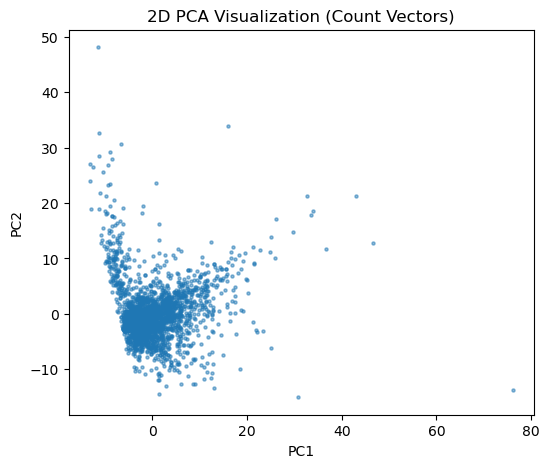

In [11]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Convert count_matrix to array if not already done
X_count = count_matrix.toarray()

# 1. Apply PCA and reduce to 2 components
pca = PCA(n_components=2)
X_count_pca = pca.fit_transform(X_count)

print("PCA output shape:", X_count_pca.shape)

# 2. Scatter plot
plt.figure(figsize=(6, 5))
plt.scatter(X_count_pca[:, 0], X_count_pca[:, 1], s=5, alpha=0.5)
plt.title("2D PCA Visualization (Count Vectors)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

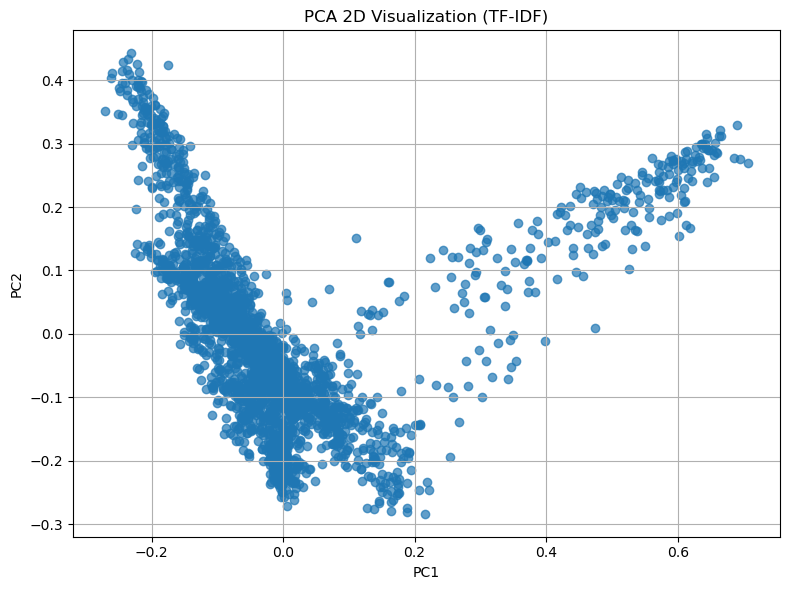

c:\Users\pravi\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


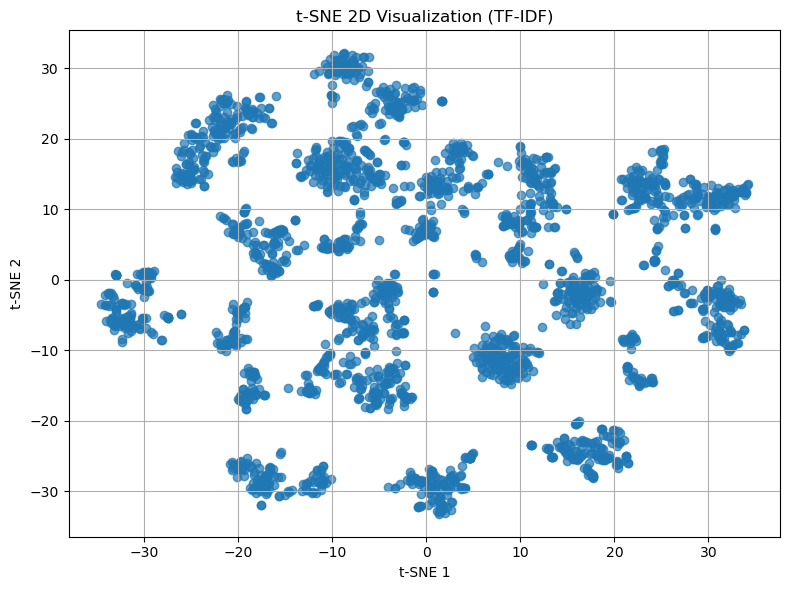

In [12]:
# PCA and t-SNE visualizations for TF-IDF vectors
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# PCA analysis
pca = PCA(n_components=2, random_state=42)
tfidf_pca = pca.fit_transform(tfidf_array)

plt.figure(figsize=(8,6))
plt.scatter(tfidf_pca[:,0], tfidf_pca[:,1], alpha=0.7)
plt.title('PCA 2D Visualization (TF-IDF)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True)
plt.tight_layout()
plt.show()

# t-SNE analysis
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=500)
tfidf_tsne = tsne.fit_transform(tfidf_array)

plt.figure(figsize=(8,6))
plt.scatter(tfidf_tsne[:,0], tfidf_tsne[:,1], alpha=0.7)
plt.title('t-SNE 2D Visualization (TF-IDF)')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.grid(True)
plt.tight_layout()
plt.show()

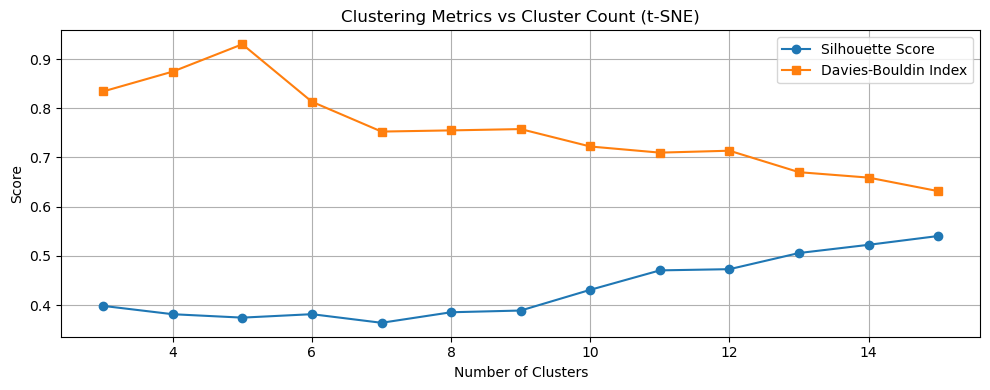

Optimal cluster count (by Silhouette): 15


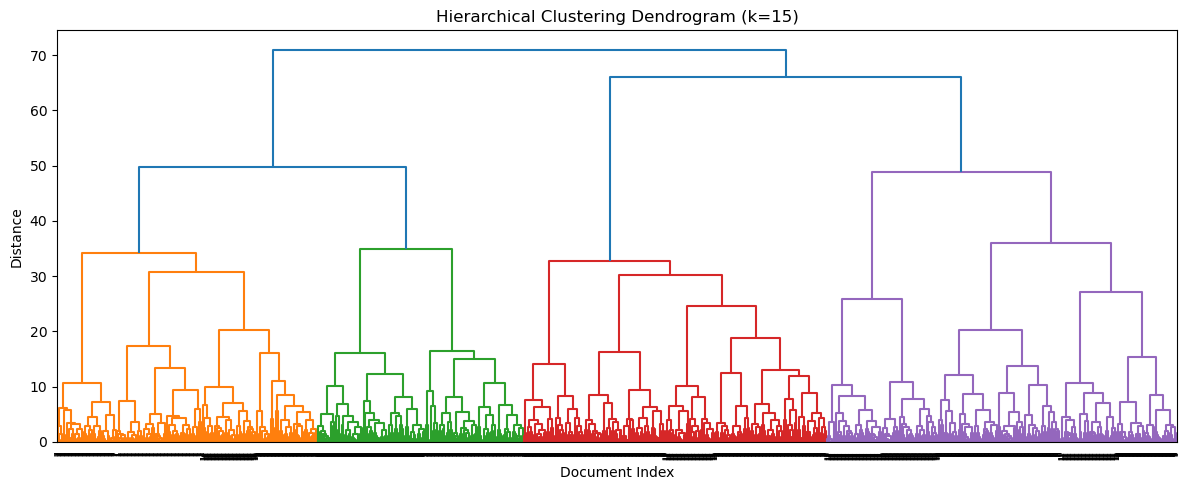

tsne_cluster
0     279
1     195
2     254
3     225
4     184
5     138
6     245
7     136
8     138
9     135
10    128
11    130
12    124
13    114
14    123
Name: count, dtype: int64


In [ ]:
# Hierarchical Clustering directly on TF-IDF vectors, metrics, and dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import numpy as np

# Range of cluster counts to try
cluster_range = range(3, 16)
sil_scores = []
db_scores = []

for n_clusters in cluster_range:
    hc = AgglomerativeClustering(n_clusters=n_clusters, linkage='complete')
    labels = hc.fit_predict(tfidf_array)
    sil = silhouette_score(tfidf_array, labels)
    db = davies_bouldin_score(tfidf_array, labels)
    sil_scores.append(sil)
    db_scores.append(db)

# Plot Silhouette and Davies-Bouldin scores
plt.figure(figsize=(10,4))
plt.plot(cluster_range, sil_scores, marker='o', label='Silhouette Score')
plt.plot(cluster_range, db_scores, marker='s', label='Davies-Bouldin Index')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Clustering Metrics vs Cluster Count (TF-IDF)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Choose optimal cluster count (highest Silhouette, lowest DB)
optimal_clusters = cluster_range[np.argmax(sil_scores)]
print(f'Optimal cluster count (by Silhouette): {optimal_clusters}')

# Final clustering and dendrogram
hc_final = AgglomerativeClustering(n_clusters=optimal_clusters, linkage='complete')
final_labels = hc_final.fit_predict(tfidf_array)

# Dendrogram
linked = linkage(tfidf_array, 'complete')
plt.figure(figsize=(12,5))
dendrogram(linked, labels=final_labels, color_threshold=None)
plt.title(f'Hierarchical Clustering Dendrogram (TF-IDF, k={optimal_clusters})')
plt.xlabel('Document Index')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

# Save cluster assignments to spreadsheet
df['tfidf_cluster'] = final_labels
df.to_excel('tfidf_clusters.xlsx', index=False)

# Quick cluster analysis: show cluster sizes
print(df['tfidf_cluster'].value_counts().sort_index())

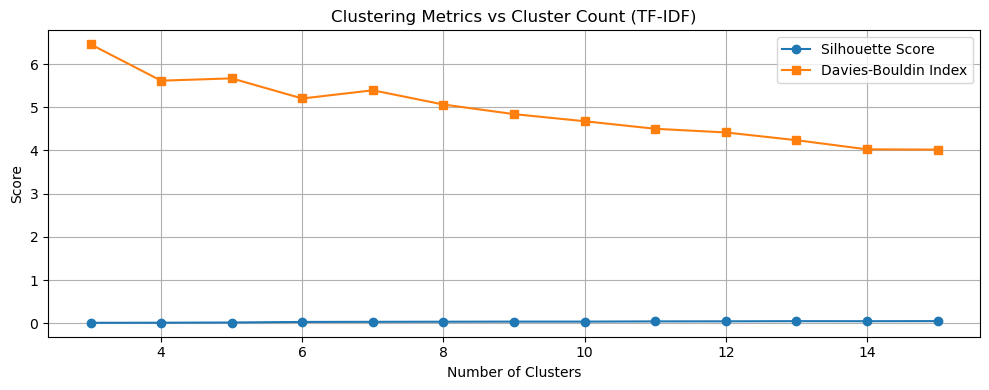

Optimal cluster count (by Silhouette): 15


PermissionError: [Errno 13] Permission denied: 'tfidf_clusters.xlsx'

In [14]:
# Hierarchical Clustering directly on TF-IDF vectors, metrics, and dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import numpy as np

# Range of cluster counts to try
cluster_range = range(3, 16)
sil_scores = []
db_scores = []

for n_clusters in cluster_range:
    hc = AgglomerativeClustering(n_clusters=n_clusters, linkage='complete')
    labels = hc.fit_predict(tfidf_array)
    sil = silhouette_score(tfidf_array, labels)
    db = davies_bouldin_score(tfidf_array, labels)
    sil_scores.append(sil)
    db_scores.append(db)

# Plot Silhouette and Davies-Bouldin scores
plt.figure(figsize=(10,4))
plt.plot(cluster_range, sil_scores, marker='o', label='Silhouette Score')
plt.plot(cluster_range, db_scores, marker='s', label='Davies-Bouldin Index')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Clustering Metrics vs Cluster Count (TF-IDF)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Choose optimal cluster count (highest Silhouette, lowest DB)
optimal_clusters = cluster_range[np.argmax(sil_scores)]
print(f'Optimal cluster count (by Silhouette): {optimal_clusters}')

# Final clustering and dendrogram
hc_final = AgglomerativeClustering(n_clusters=optimal_clusters, linkage='complete')
final_labels = hc_final.fit_predict(tfidf_array)

# # Dendrogram
# linked = linkage(tfidf_array, 'complete')
# plt.figure(figsize=(12,5))
# dendrogram(linked, labels=final_labels, color_threshold=None)
# plt.title(f'Hierarchical Clustering Dendrogram (TF-IDF, k={optimal_clusters})')
# plt.xlabel('Document Index')
# plt.ylabel('Distance')
# plt.tight_layout()
# plt.show()

# Save cluster assignments to spreadsheet
df['tfidf_cluster'] = final_labels
df.to_excel('tfidf_clusters.xlsx', index=False)

# Quick cluster analysis: show cluster sizes
print(df['tfidf_cluster'].value_counts().sort_index())

In [ ]:
# Print sample text from each TF-IDF cluster
for cluster_num in sorted(df['tfidf_cluster'].unique()):
    print(f"\nCluster {cluster_num} sample:")
    sample = df[df['tfidf_cluster'] == cluster_num]['preprocessed_text'].iloc[0]
    print(sample[:500])